# Часть 1

Для оптимальной работы вспомогательных библиотек, папка scikit назвается scikit_uplift и положена в корень, где лежит ноутбук

In [100]:
# mle-uplift-final-project-2025/
# ├── __pycache__/
# ├── catboost_info/
# ├── scikit_uplift/
# ├── final_project_template.ipynb
# ├── README.md
# ├── requirements.txt
# ├── uplift_gp_data.csv
# └── utils.py


## Этап 1

In [40]:
import pandas as pd
import numpy as np

from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.meta import BaseSClassifier, BaseTClassifier

from catboost import CatBoostClassifier


from scikit_uplift.metrics.metrics import uplift_auc_score, qini_auc_score, uplift_at_k
from scikit_uplift.viz.base import plot_uplift_curve, plot_qini_curve


# стиль визуализаций
sns.set(style="whitegrid")

import numpy as np
from scipy import stats



In [2]:
data = pd.read_csv('uplift_fp_data.csv')
data.head(5)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recency          64000 non-null  int64  
 1   history_segment  64000 non-null  int64  
 2   history          64000 non-null  float64
 3   mens             64000 non-null  int64  
 4   womens           64000 non-null  int64  
 5   zip_code         64000 non-null  int64  
 6   newbie           64000 non-null  int64  
 7   channel          64000 non-null  int64  
 8   treatment        64000 non-null  int64  
 9   target           64000 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 4.9 MB


In [3]:
# Проверка пропусков по столбцам
na_cnt = data.isna().sum().sort_values(ascending=False)
display(na_cnt)


# # Проверка дубликатов строк
display(data[data.duplicated()])
dup_cnt = data.duplicated().sum()
print("Количество полных дубликатов строк:", dup_cnt)

# # Если дубликаты есть, удаляем их, фиксируя изменение размера датасета
if dup_cnt > 0:
    before = data.shape[0]
    data = data.drop_duplicates().reset_index(drop=True)
    after = data.shape[0]
    print("Размер до удаления дубликатов:", before)
    print("Размер после удаления дубликатов:", after)


recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
treatment          0
target             0
dtype: int64

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
149,2,0,29.99,0,1,1,0,1,0,0
167,7,0,29.99,1,0,1,1,2,1,0
526,10,0,29.99,1,0,0,0,2,1,0
606,10,0,29.99,1,0,1,1,2,0,0
654,10,0,29.99,1,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...
63952,10,0,29.99,1,0,2,1,2,0,0
63955,1,0,29.99,1,0,1,0,1,0,0
63977,8,0,29.99,0,1,1,0,2,0,1
63982,5,0,29.99,1,0,0,1,1,0,0


Количество полных дубликатов строк: 7015
Размер до удаления дубликатов: 64000
Размер после удаления дубликатов: 56985


**Вывод (Этап 1. Первичная подготовка данных)**

Пропусков в датасете не обнаружен
Дубликаты были обнаружены и удалены


## Этап 2

### EDA


In [17]:

display(data.describe())
data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
count,56985.000000,56985.000000,56985.000000,56985.000000,56985.000000,56985.000000,56985.000000,56985.000000,56985.000000,56985.000000
mean,5.657401,1.663859,268.117295,0.556901,0.556252,0.751636,0.502641,1.296832,0.336211,0.155199
std,3.502217,1.541509,259.796627,0.496756,0.496830,0.700899,0.499997,0.693602,0.472416,0.362097
min,1.000000,0.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,90.690000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,5.000000,1.000000,185.140000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,3.000000,354.140000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
max,12.000000,6.000000,3345.930000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment,target
0,10,1,142.44,1,0,1,0,1,1,0
1,6,2,329.08,1,1,2,1,2,0,0
2,7,1,180.65,0,1,1,1,2,1,0
3,9,4,675.83,1,0,2,1,2,0,0
4,2,0,45.34,1,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...
56980,7,0,86.46,0,1,0,0,2,0,0
56981,10,1,105.54,1,0,0,0,2,0,0
56982,5,0,38.91,0,1,0,1,1,0,0
56983,1,4,552.94,1,0,1,1,0,1,0


In [25]:
# проверка уникальных значений категориальных признаков
categorical_cols = [
    'history_segment', 'mens', 'womens',
    'zip_code', 'newbie', 'channel',
]

for col in categorical_cols:
    print(f"{col}: {data[col].unique()}")


history_segment: [1 2 4 0 5 3 6]
mens: [1 0]
womens: [0 1]
zip_code: [1 2 0]
newbie: [0 1]
channel: [1 2 0]


In [30]:
# распределение воздействия
treatment_counts = data['treatment'].value_counts().sort_index()
display(treatment_counts)
# распределение таргета
target_counts = data['target'].value_counts().sort_index()
display(target_counts)


treatment
0    37826
1    19159
Name: count, dtype: int64

target
0    48141
1     8844
Name: count, dtype: int64

target,0,1
treatment,,
0,0.847327,0.152673
1,0.839814,0.160186


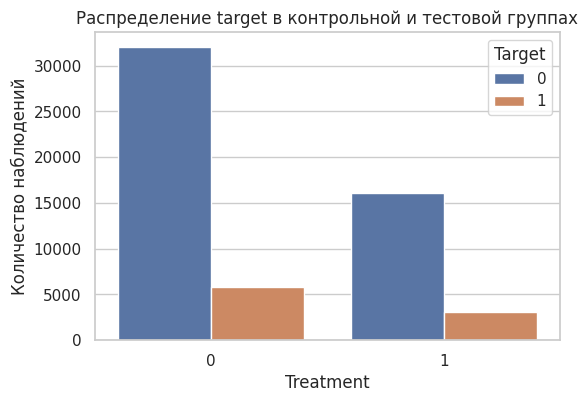

In [ ]:
# таблица сопряжённости treatment и target
ct_table = pd.crosstab(
    data['treatment'],
    data['target'],
    normalize='index'
)

display(ct_table)

# визуализация распределения target по группам
plt.figure(figsize=(6, 4))
sns.countplot(
    data=data,
    x='treatment',
    hue='target'
)
plt.title('Распределение target в контрольной и тестовой группах')
plt.xlabel('Treatment')
plt.ylabel('Количество наблюдений')
plt.legend(title='Target')
plt.show()



/tmp/ipykernel_27546/3018341606.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


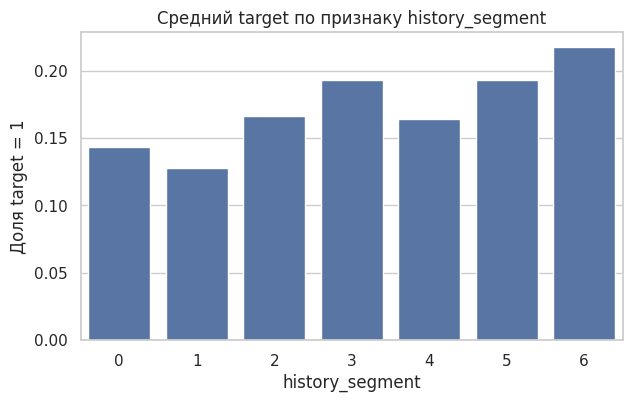

/tmp/ipykernel_27546/3018341606.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


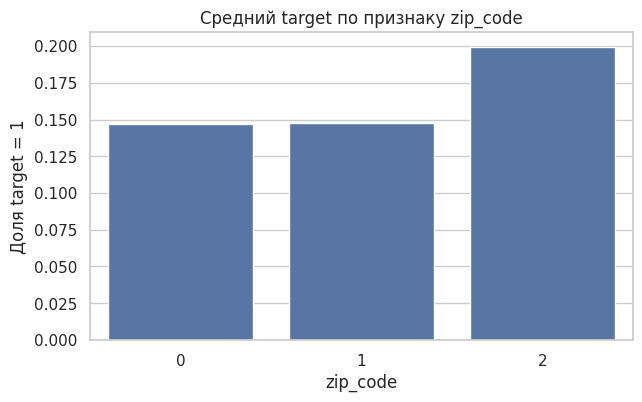

/tmp/ipykernel_27546/3018341606.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


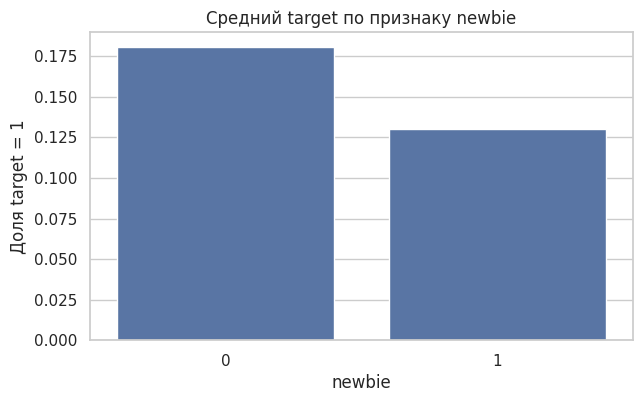

/tmp/ipykernel_27546/3018341606.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


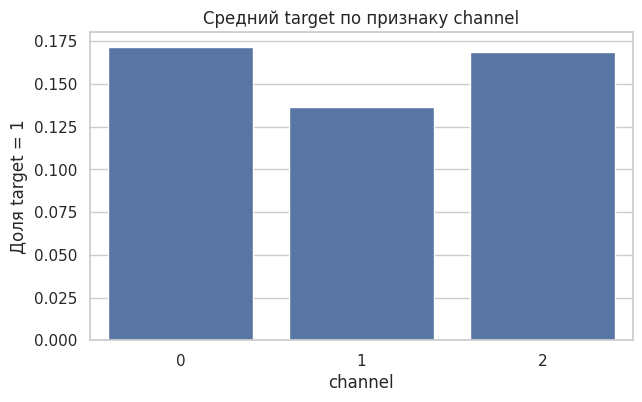

In [26]:
categorical_features = [
    'history_segment',
    'zip_code',
    'newbie',
    'channel'
]

for col in categorical_features:
    plt.figure(figsize=(7, 4))
    sns.barplot(
        data=data,
        x=col,
        y='target',
        estimator='mean',
        ci=None
    )
    plt.title(f'Средний target по признаку {col}')
    plt.ylabel('Доля target = 1')
    plt.xlabel(col)
    plt.show()


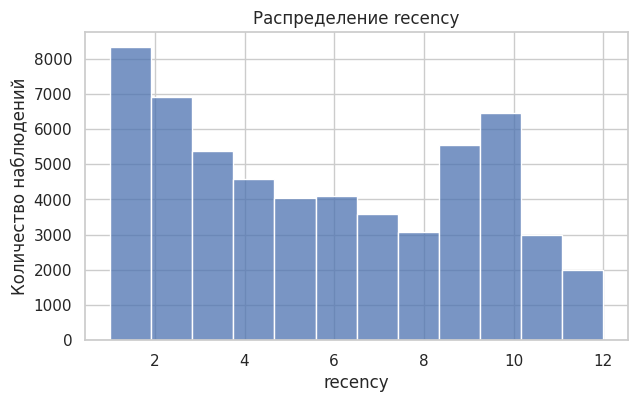

In [27]:
plt.figure(figsize=(7, 4))
sns.histplot(data=data, x='recency', bins=12, kde=False)
plt.title('Распределение recency')
plt.xlabel('recency')
plt.ylabel('Количество наблюдений')
plt.show()


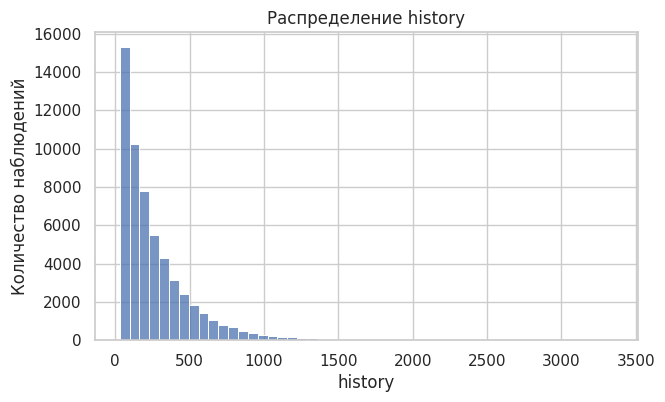

0.50     185.1400
0.75     354.1400
0.90     592.0800
0.95     780.2780
0.99    1252.0976
Name: history, dtype: float64

In [29]:
plt.figure(figsize=(7, 4))
sns.histplot(data=data, x='history', bins=50, kde=False)
plt.title('Распределение history')
plt.xlabel('history')
plt.ylabel('Количество наблюдений')
plt.show()

display(data['history'].quantile([0.5, 0.75, 0.9, 0.95, 0.99])
)


Сделайте вывод на основе EDA в данной ячейке

**Выводы по EDA**

Целевая переменная target бинарная и заметно несбалансированная: отклик составляет около 15–16% от всей выборки.  
В тестовой группе доля отклика немного выше, чем в контрольной, что говорит о наличии эффекта от промокода и корректной разметке эксперимента.

Признак history_segment связан с target: по мере роста сегмента увеличивается доля пользователей, которые используют промокод. Это ожидаемо и согласуется с бизнес-логикой — клиенты с более высокой историей трат чаще реагируют на предложение.

По признаку zip_code наблюдаются различия в среднем уровне отклика между категориями, что указывает на географическую неоднородность аудитории.  
Признак channel также показывает различия в отклике между каналами, что может быть важно при дальнейшем моделировании.

Признак recency имеет дискретное распределение без выраженных выбросов.  
Признак history распределён неравномерно и имеет длинный правый хвост: большая часть клиентов тратит относительно небольшие суммы, при этом присутствует небольшое число клиентов с очень высокими значениями. По квантилям видно, что 99% наблюдений лежат ниже ~1250.

В целом данные содержат выраженную неоднородность по признакам и по отклику, что делает задачу подходящей для uplift-моделирования, а не для обычного бинарного классификатора.


# Этап 2

### Проверка на статистическую значимость

In [32]:
# разделение на контрольную и тестовую группы
control = data.loc[data['treatment'] == 0, 'target']
test = data.loc[data['treatment'] == 1, 'target']

# доля отклика (target = 1) по группам
p_control = control.mean()
p_test = test.mean()

# стандартное отклонение для бинарной переменной (Бернулли)
std_control = np.sqrt(p_control * (1 - p_control))
std_test = np.sqrt(p_test * (1 - p_test))

# вывод основных метрик по группам
print("Размер контрольной группы:", control.shape[0])
print("Размер тестовой группы:", test.shape[0])
print("Доля отклика в контрольной группе:", round(p_control, 6))
print("Доля отклика в тестовой группе:", round(p_test, 6))
print("Std(target) в контрольной группе:", round(std_control, 6))
print("Std(target) в тестовой группе:", round(std_test, 6))
print("Разница долей (test - control):", round(p_test - p_control, 6))


Размер контрольной группы: 37826
Размер тестовой группы: 19159
Доля отклика в контрольной группе: 0.152673
Доля отклика в тестовой группе: 0.160186
Std(target) в контрольной группе: 0.359672
Std(target) в тестовой группе: 0.366778
Разница долей (test - control): 0.007513


Обоснуйте выбор статистического теста в данной ячейке

**Обоснование выбора статистического теста**

В рамках задачи необходимо проверить, различается ли доля отклика (target = 1) между контрольной и тестовой группами, сформированными по признаку treatment.

Переменная target является бинарной, а сравнение проводится между двумя независимыми выборками.Поэтому таблица сопряжённости будем иметь размерность 2×2 (treatment × target).

Для проверки гипотезы о наличии связи между воздействием и откликом используется χ²-тест независимости. Данный тест позволяет определить, зависит ли распределение бинарной целевой переменной от принадлежности наблюдения к контрольной или тестовой группе.

Размеры обеих групп достаточно велики, поэтому предпосылки применения χ²-теста выполняются, а асимптотическое приближение является корректным. Уровень значимости принят равным 0.05.


In [37]:
# таблица сопряжённости treatment × target
# доли отклика (target = 1) по группам на основе таблицы сопряжённости
table = pd.crosstab(data['treatment'], data['target'])

p_control = table.loc[0, 1] / table.loc[0].sum()
p_test = table.loc[1, 1] / table.loc[1].sum()
delta_pp = (p_test - p_control) * 100

print("Доля отклика в контрольной группе:", round(p_control, 6))
print("Доля отклика в тестовой группе:", round(p_test, 6))
print("Разница долей (test - control):", round(delta_pp, 3))

# χ²-тест независимости
chi2, p_value, dof, expected = stats.chi2_contingency(table)

print("Таблица сопряжённости (treatment x target):")
display(table)

print("chi2:", round(chi2, 6))
print("p-value:", p_value)
print("dof:", dof)


Доля отклика в контрольной группе: 0.152673
Доля отклика в тестовой группе: 0.160186
Разница долей (test - control): 0.751
Таблица сопряжённости (treatment x target):


target,0,1
treatment,,
0,32051,5775
1,16090,3069


chi2: 5.417951
p-value: 0.019930731150021908
dof: 1


**Результаты проверки на статистическую значимость**

В контрольной группе доля отклика составляет 15.27%, в тестовой группе — 16.02%. Разница долей между группами равна 0.75 процентного пункта в пользу тестовой группы.

По результатам χ²-теста независимости получено p-value = 0.0199, что меньше уровня значимости 0.05
Нулевая гипотеза об отсутствии различий между группами отвергается.  
Различие в доле отклика между группами статистически значимо, т.е. возможно обучать модель uplift


## Построение корреляций

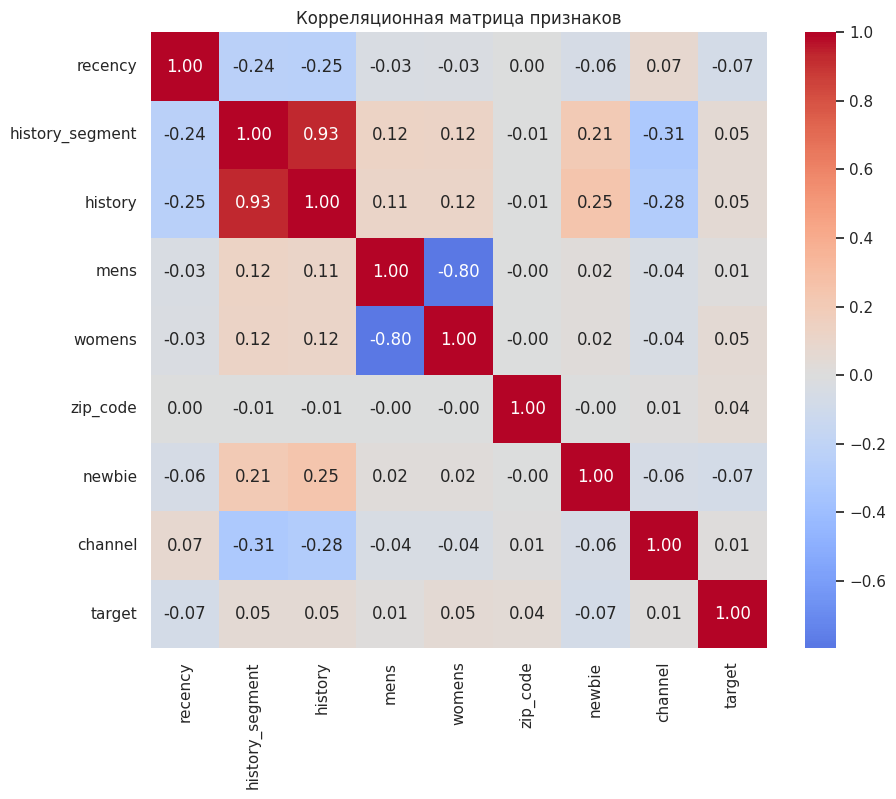

In [40]:
# выбор признаков для корреляционного анализа
corr_features = [
    'recency',
    'history_segment',
    'history',
    'mens',
    'womens',
    'zip_code',
    'newbie',
    'channel',
    'target'
]

# расчет корреляционной матрицы
corr_matrix = data[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Корреляционная матрица признаков")
plt.show()


Сделайте вывод о корреляциях признаков друг с другом и таргетом в этой ячейке

**Выводы по корреляционному анализу**

Наиболее сильная линейная связь наблюдается между признаками history и history_segment (корреляция около 0.93). Это ожидаемо, так как сегментация напрямую основана на величине исторических трат.

Признаки mens и womens имеют сильную отрицательную корреляцию (около −0.80), что отражает их бинарную и взаимоисключающую природу.

Признак recency умеренно отрицательно коррелирует с history и history_segment, что указывает на связь между давностью последней покупки и уровнем исторических трат.

Целевая переменная target слабо линейно коррелирует со всеми признаками. Максимальные значения корреляции по модулю не превышают 0.07, что говорит об отсутствии выраженной линейной зависимости между отдельными признаками и откликом.

В целом в данных отсутствуют сильные линейные зависимости между большинством признаков и целевой переменной. Это указывает на то, что отклик формируется под влиянием комбинаций факторов и взаимодействий, а не отдельных признаков, что дополнительно обосновывает использование uplift-моделирования.


**Итоговые выводы по EDA**

Данные в целом выглядят адекватно для дальнейшего моделирования: пропусков нет, выборка достаточно большая, признаки понятные и интерпретируемые.

Целевая переменная несбалансированная, но это ожидаемо для задачи отклика на маркетинговое предложение. При этом в тестовой группе доля отклика статистически значимо выше, чем в контрольной, что подтверждает наличие эффекта от промокода и корректность эксперимента.

Связь между отдельными признаками и target слабая, сильных линейных зависимостей не наблюдается. Это означает, что отклик пользователя вряд ли определяется каким-то одним фактором. Исключение составляют ожидаемые зависимости: history сильно связано с history_segment, а признаки mens и womens отрицательно коррелируют между собой.

Распределение признака history имеет длинный правый хвост — большая часть клиентов тратит умеренные суммы, но есть небольшое число клиентов с очень высокими тратами. Признак recency распределён более равномерно и не содержит экстремальных значений.

В целом данные выглядят неоднородными, а эффект воздействия различается между сегментами клиентов. Это делает задачу подходящей для uplift-моделирования, так как классический классификатор не позволит корректно оценить, кому промокод действительно приносит дополнительный эффект.


# Этап 3

Обоснуйте выбор конкретной uplift модели в данной ячейке

**Обоснование выбора baseline uplift-модели**

В качестве baseline выбрана модель uplift-деревьев UpliftRandomForestClassifier из библиотеки causalml.

Данный алгоритм является специализированным решением для uplift-задач: при построении деревьев он учитывает разделение на контрольную и тестовую группы и стремится находить такие разбиения признакового пространства, где эффект воздействия отличается сильнее всего. Это делает модель подходящей для задачи выбора аудитории, которой промокод действительно увеличивает вероятность отклика.

Для табличных данных с возможными нелинейностями и взаимодействиями признаков uplift-деревья часто показывают стабильные результаты без сложной предобработки. Также модель позволяет анализировать важность признаков и имеет небольшой набор понятных гиперпараметров, что удобно для дальнейшего улучшения качества по метрике Uplift@30.


### Советы по обучению и инференсу моделей
1. Некоторые uplift модели из библиотеки `causalml` будут требовать категориальные значения воздействия. Для этого используйте маппинг
#### Пример использования маппинга
```python
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}
treatment_train_mapped = treatment_train.map(treatment_mapping)
treatment_test_mapped = treatment_test.map(treatment_mapping)
```

2. При вызове метода `.predict` и получения метрик для тестовой выборки не забывайте применять к прогнозам метод `squeeze()`, чтобы преобразовать многомерный массив в одномерный, что поможет получить адекватные метрики.

3. Для воспроизводимости результатов и объективной оценки не забывайте применять `random_state=42` для моделей, а также при разделении выборки

### Разбиение выборки на тренировочную и тестовую

In [ ]:
# признаки и целевая переменная
X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'], axis=1), data['target'], test_size=0.2, 
                                    stratify=data[['target', 'treatment']],
                                    random_state=42)


Failed to import duecredit due to No module named 'duecredit'


### Обучение выбранного бейзлайна

In [19]:
# признаки без treatment
X_train_features = X_train.drop(columns=['treatment'])

# маппинг treatment
treatment_mapping = {
    0: 'control',
    1: 'treatment'
}

treatment_train = X_train['treatment']
treatment_test = X_test['treatment']


uplift_model = UpliftRandomForestClassifier(
    control_name='control',
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=100,
    random_state=42
)

uplift_model.fit(
    X=X_train.drop(columns=['treatment']).values,
    treatment=treatment_train.map(treatment_mapping).values,
    y=y_train.values
)



### Расчет метрик для выбранного бейзлайна на тестовой выборке

In [20]:
uplift_preds = uplift_model.predict(
    X_test.drop(columns=['treatment']).values
).squeeze()


Uplift AUC: 0.030994318093755028
Qini AUC: 0.06589014780732105
Uplift@30%: 0.049406318189860216


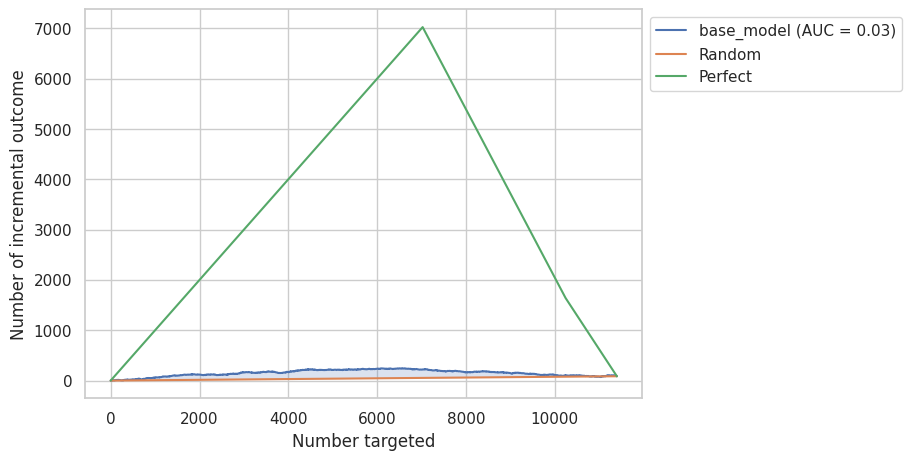

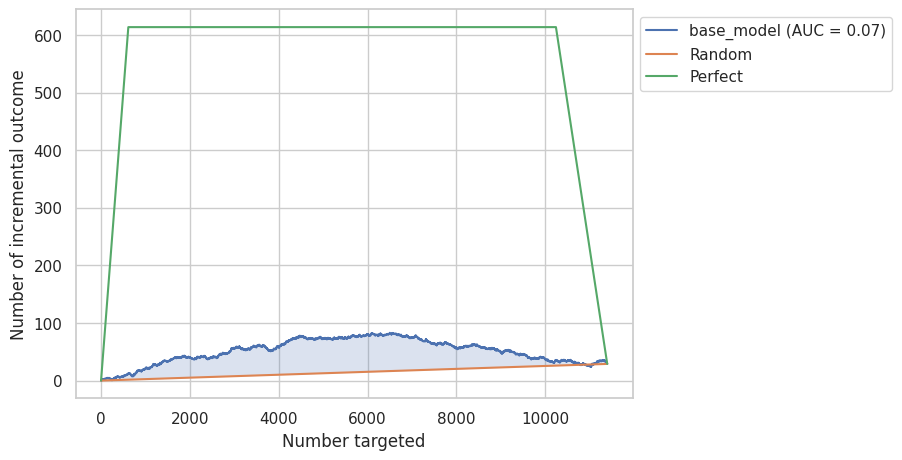

In [30]:

uplift_auc = uplift_auc_score(y_test, uplift_preds, treatment_test)
qini_auc = qini_auc_score(y_test, uplift_preds, treatment_test)
uplift_30 = uplift_at_k(y_test, uplift_preds, treatment_test, k=0.3, strategy='overall')

print("Uplift AUC:", uplift_auc)
print("Qini AUC:", qini_auc)
print("Uplift@30%:", uplift_30)

plot_uplift_curve(y_test, uplift_preds, treatment_test, name='base_model')
plot_qini_curve(y_test, uplift_preds, treatment_test, name='base_model')



# Обучение 2 моделей 

### Обучение модели 1

In [88]:
# базовая модель классификации
learner = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=100,
    random_state=42
)

# S-learner на основе causalml
s_learner = BaseSClassifier(
    learner=learner,
    control_name=0
)

# обучение S-learner
s_learner.fit(
    X=X_train.values,
    treatment=X_train['treatment'].values,
    y=y_train.values
)

# uplift-предсказания
uplift_preds_s = s_learner.predict(X_test.values).squeeze()



In [92]:
X_test

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,treatment
12180,3,1,114.25,1,0,0,1,1,0
13932,1,1,105.89,1,0,1,1,2,1
20506,9,1,116.84,1,0,1,1,2,1
13861,1,2,285.03,1,1,0,1,2,0
40962,11,0,86.71,0,1,1,0,2,1
...,...,...,...,...,...,...,...,...,...
44520,3,3,415.14,1,1,1,0,0,1
20356,2,0,58.23,0,1,0,1,1,0
47684,3,3,445.22,0,1,1,0,0,0
3428,7,1,114.08,1,0,1,1,2,0


### Получение метрик по модели 1

Uplift AUC: 0.02961857469622881
Qini AUC: 0.062348399693276886
Uplift@30%: 0.05175484507149086


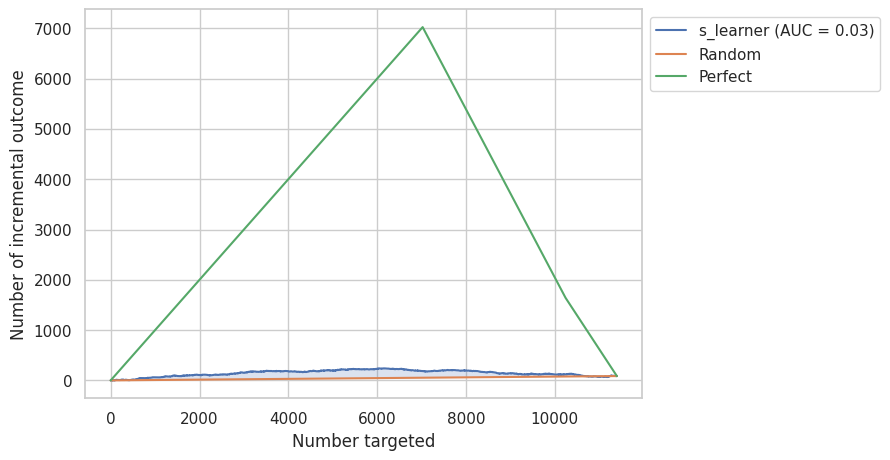

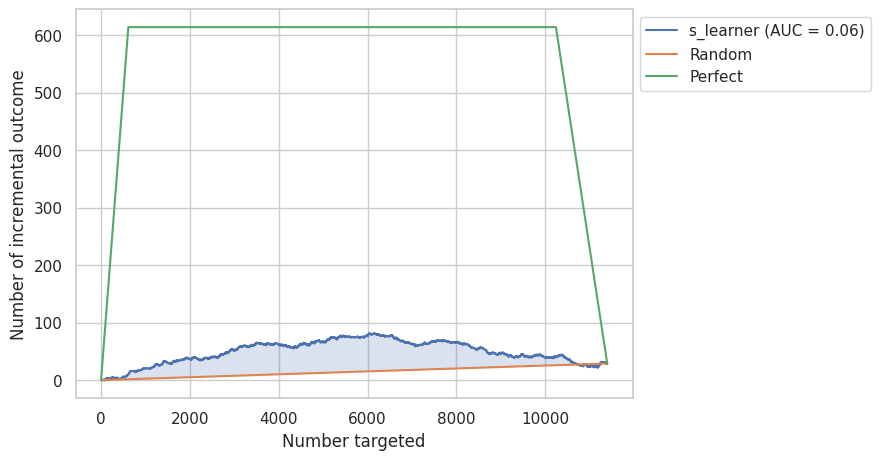

In [73]:

uplift_auc = uplift_auc_score(y_test, uplift_preds_s, treatment_test)
qini_auc = qini_auc_score(y_test, uplift_preds_s, treatment_test)
uplift_30 = uplift_at_k(y_test, uplift_preds_s, treatment_test, k=0.3, strategy='overall')

print("Uplift AUC:", uplift_auc)
print("Qini AUC:", qini_auc)
print("Uplift@30%:", uplift_30)

plot_uplift_curve(y_test, uplift_preds_s, treatment_test, name='s_learner')
plot_qini_curve(y_test, uplift_preds_s, treatment_test, name='s_learner')



### Обучение модели 2

In [27]:


# базовая модель для группы воздействия
treatment_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=100,
    random_state=42
)

# базовая модель для контрольной группы
control_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=100,
    random_state=42
)

# T-learner на основе causalml
t_learner = BaseTClassifier(
    treatment_learner=treatment_model,
    control_learner=control_model,
    control_name=0
)

# обучение T-learner
t_learner.fit(
    X=X_train.values,
    treatment=X_train['treatment'].values,
    y=y_train.values
)

# uplift-предсказания
uplift_preds_t = t_learner.predict(X_test.values).squeeze()


### Получение метрик по модели 2

Uplift AUC: 0.02830799333851467
Qini AUC: 0.05947452636400064
Uplift@30%: 0.04491809720691062


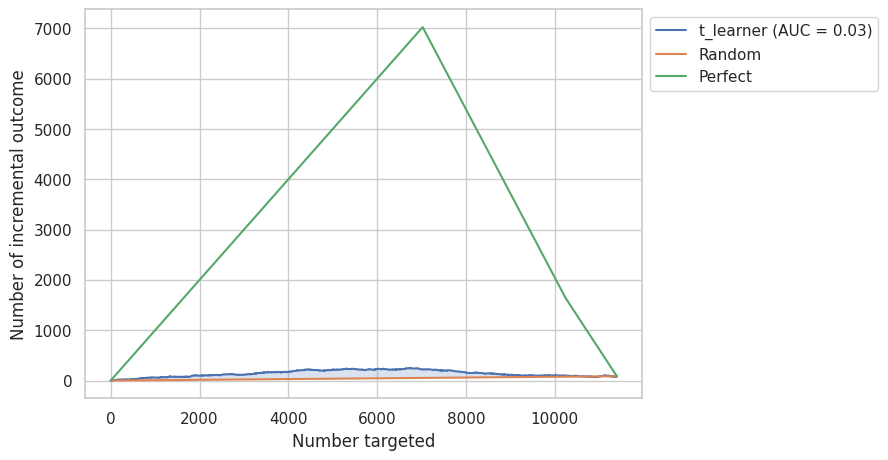

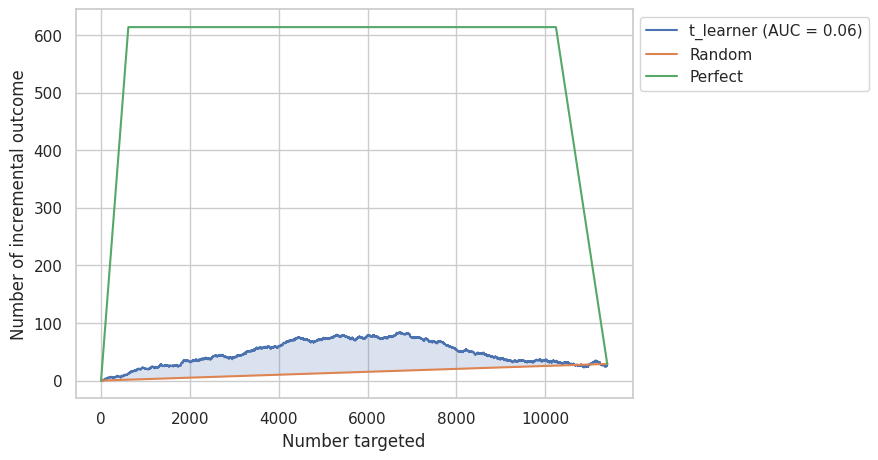

In [33]:
uplift_auc_t = uplift_auc_score(y_test, uplift_preds_t, treatment_test)
qini_auc_t = qini_auc_score(y_test, uplift_preds_t, treatment_test)
uplift_30_t = uplift_at_k(y_test, uplift_preds_t, treatment_test, k=0.3, strategy='overall')

print("Uplift AUC:", uplift_auc_t)
print("Qini AUC:", qini_auc_t)
print("Uplift@30%:", uplift_30_t)

plot_uplift_curve(y_test, uplift_preds_t, treatment_test, name='t_learner')
plot_qini_curve(y_test, uplift_preds_t, treatment_test, name='t_learner')


Проинтерпретируйте полученные результаты и обоснуйте выбор 1 модели в этой ячейке

В рамках этапа были обучены и сравнены три uplift-подхода:
baseline-модель (ручной S-learner), BaseSClassifier и BaseTClassifier из библиотеки causalml.

По всем основным метрикам (Uplift AUC, Qini AUC и Uplift@30%) модели показали близкие и невысокие значения. Это говорит о том, что эффект воздействия в данных присутствует, но он слабый и плохо сегментируется по доступным признакам. Графики uplift и Qini-кривых подтверждают этот вывод: кривые моделей лишь незначительно превосходят случайную стратегию и имеют схожую форму.

BaseTClassifier, несмотря на более сложную архитектуру (две отдельные модели для treatment и control), не продемонстрировал улучшения качества по сравнению с S-learner. Это указывает на то, что разделение данных на две подвыборки не даёт дополнительной информации для более точной оценки uplift-эффекта, вероятно из-за ограниченной информативности признаков и небольшого различия между группами.

В качестве итоговой модели была выбрана S-learner (BaseSClassifier), поскольку:
- он показывает сопоставимое или лучшее качество по всем метрикам;
- обладает более простой и устойчивой архитектурой;
- требует меньших вычислительных затрат;
- легче интерпретируется и удобнее в дальнейшем использовании.

Таким образом, в условиях текущих данных усложнение модели не приводит к росту качества, и использование S-learner является наиболее разумным и обоснованным выбором.

# Часть 2

## Этап 1
Улучшите бейзлайн выбранной модели

In [ ]:
def eval_s_learner_causalml(learner, X_train_, X_test_, y_train_, y_test_, name: str) -> dict:
    # S-learner через causalml
    model = BaseSClassifier(learner=learner, control_name=0)

    model.fit(
        X=X_train_.values,
        treatment=X_train_["treatment"].values,
        y=y_train_.values
    )

    uplift_pred = model.predict(X_test_.values).squeeze()

    uplift_30 = uplift_at_k(
        y_true=y_test_.values,
        uplift=uplift_pred,
        treatment=X_test_["treatment"].values,
        k=0.3,
        strategy="overall"
    )

    return {"model": name, "uplift@30": float(uplift_30)}


def eval_s_learner_manual(learner, X_train_, X_test_, y_train_, y_test_, name: str) -> dict:
    # S-learner в ручной реализации: обучение одной модели с treatment как признаком
    learner.fit(X_train_, y_train_)

    X_test_treated = X_test_.copy()
    X_test_control = X_test_.copy()

    X_test_treated["treatment"] = 1
    X_test_control["treatment"] = 0

    p_treat = learner.predict_proba(X_test_treated)[:, 1]
    p_ctrl = learner.predict_proba(X_test_control)[:, 1]

    uplift_pred = p_treat - p_ctrl

    uplift_30 = uplift_at_k(
        y_true=y_test_.values,
        uplift=uplift_pred,
        treatment=X_test_["treatment"].values,
        k=0.3,
        strategy="overall"
    )

    return {"model": name, "uplift@30": float(uplift_30)}


results = []

lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)
results.append(eval_s_learner_causalml(lr, X_train, X_test, y_train, y_test, "S-learner + LogisticRegression"))

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_leaf=50,
    min_samples_split=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
results.append(eval_s_learner_causalml(rf, X_train, X_test, y_train, y_test, "S-learner + RandomForest"))

cb = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    random_seed=42,
    verbose=False
)
results.append(eval_s_learner_manual(cb, X_train, X_test, y_train, y_test, "S-learner + CatBoost"))

results_df = pd.DataFrame(results).sort_values("uplift@30", ascending=False)
display(results_df)

print("Best baseline candidate:", results_df.iloc[0]["model"])
print("Best uplift@30:", results_df.iloc[0]["uplift@30"])


,model,uplift@30
2,S-learner + CatBoost,0.038985
1,S-learner + RandomForest,0.038614
0,S-learner + LogisticRegression,0.011798


Best baseline candidate: S-learner + CatBoost
Best uplift@30: 0.03898522800256907


Попробовали заменить базовый алгоритм в S-learner (логистическая регрессия, случайный лес, CatBoost), но заметного роста метрики Uplift@30% это не дало. Значения оказались на том же уровне или ниже.

Текущая модель S-learner с RandomForestClassifier уже превышает минимально требуемый порог качества и показывает стабильный результат, поэтому дальнейшие улучшения будем делать на ней, не меняя алгоритм.

#### Генерация признаков (опционально)

In [101]:
# квантильные пороги history считаются только на train, чтобы не подглядывать в test
history_q = X_train["history"].quantile([0.5, 0.75, 0.9, 0.95]).to_dict()
history_p90 = history_q[0.9]
history_p95 = history_q[0.95]


def add_features(df: pd.DataFrame,
                 history_q_: dict,
                 history_p90_: float,
                 history_p95_: float) -> pd.DataFrame:
    """
    Генерирует дополнительные признаки для uplift-модели.

    Args:
        df (pd.DataFrame): Датафрейм с исходными признаками.
        history_q_ (dict): Квантили history, рассчитанные на train.
        history_p90_ (float): 0.9-квантиль history, рассчитанный на train.
        history_p95_ (float): 0.95-квантиль history, рассчитанный на train.

    Returns:
        pd.DataFrame: Датафрейм с добавленными признаками.
    """
    df_out = df.copy()

    # биннинг history по квантилям (границы фиксируются по train)
    bins = [-np.inf, history_q_[0.5], history_q_[0.75], history_q_[0.9], history_q_[0.95], np.inf]
    labels = [0, 1, 2, 3, 4]
    df_out["history_bin"] = pd.cut(df_out["history"], bins=bins, labels=labels).astype(int)

    # взаимодействия ценности и давности
    df_out["history_recency_ratio"] = df_out["history"] / df_out["recency"]
    df_out["history_x_recency"] = df_out["history"] * df_out["recency"]

    # флаги по верхнему хвосту history
    df_out["is_high_history"] = (df_out["history"] >= history_p90_).astype(int)
    df_out["is_very_high_history"] = (df_out["history"] >= history_p95_).astype(int)

    # комбинация: высокий history и низкий recency
    df_out["high_history_and_low_recency"] = (
        (df_out["is_high_history"] == 1) & (df_out["recency"] <= 2)
    ).astype(int)

    return df_out


X_train_fe = add_features(X_train, history_q, history_p90, history_p95)
X_test_fe = add_features(X_test, history_q, history_p90, history_p95)

print("Train shape:", X_train.shape, X_train_fe.shape)
print("Test shape:", X_test.shape, X_test_fe.shape)

print("History quantiles used:", history_q)
print("History p90:", history_p90)
print("History p95:", history_p95)


Train shape: (45588, 9) (45588, 15)
Test shape: (11397, 9) (11397, 15)
History quantiles used: {0.5: 185.015, 0.75: 353.985, 0.9: 592.2770000000003, 0.95: 783.28}
History p90: 592.2770000000003
History p95: 783.28


Uplift AUC: 0.01973321735020258
Qini AUC: 0.04182658046071442
Uplift@30%: 0.03702658067919391


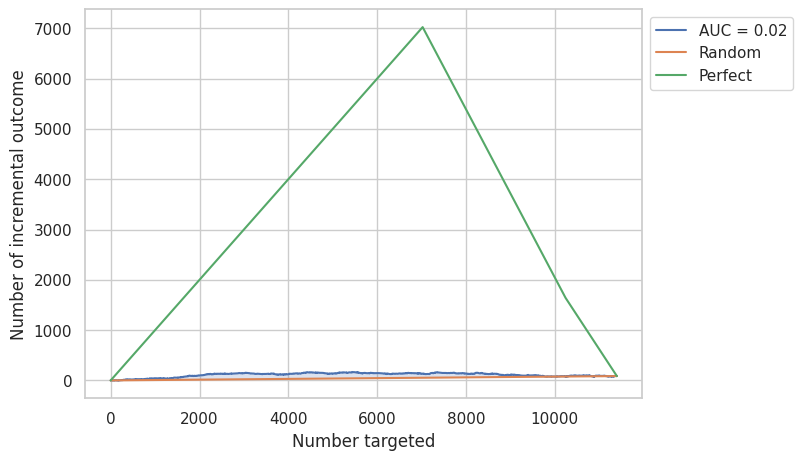

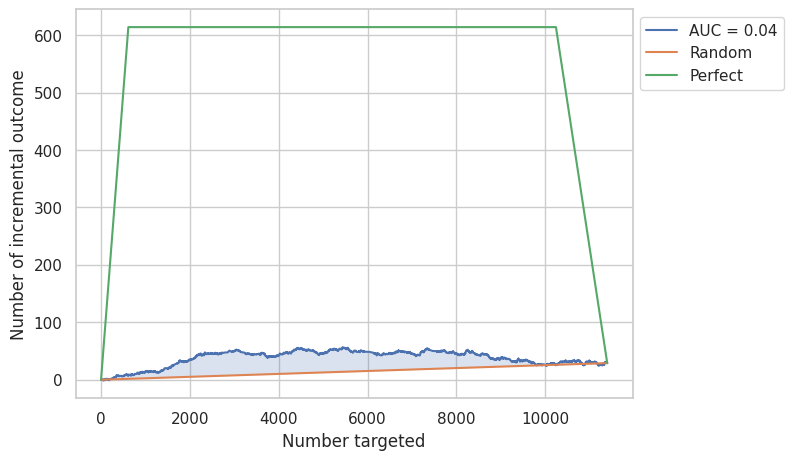

In [ ]:
# обучение S-learner на расширенных признаках
s_learner_fe.fit(
    X=X_train_fe.values,
    treatment=X_train_fe["treatment"].values,
    y=y_train.values
)

# uplift-предсказания на тесте
uplift_preds_fe = s_learner_fe.predict(X_test_fe.values).squeeze()

# метрики
uplift_auc = uplift_auc_score(y_test.values, uplift_preds_fe, X_test_fe["treatment"].values)
qini_auc = qini_auc_score(y_test.values, uplift_preds_fe, X_test_fe["treatment"].values)
uplift_30 = uplift_at_k(
    y_true=y_test.values,
    uplift=uplift_preds_fe,
    treatment=X_test_fe["treatment"].values,
    k=0.3,
    strategy="overall"
)

print("Uplift AUC:", uplift_auc)
print("Qini AUC:", qini_auc)
print("Uplift@30%:", uplift_30)

# графики uplift и qini
plot_uplift_curve(y_test.values, uplift_preds_fe, X_test_fe["treatment"].values)
plt.show()

plot_qini_curve(y_test.values, uplift_preds_fe, X_test_fe["treatment"].values)
plt.show()

Пробы улучшить модель за счёт смены алгоритма и простого feature engineering не дали прироста качества. Лучшие значения Uplift@30 остаются у исходного бейзлайна S-learner на RandomForest

### Подбор гиперпараметров

In [ ]:
# from optuna import create_study
# from scikit_uplift.metrics.metrics import uplift_at_k

# def objective(trial):
#     # Дополните код для подбора гиперпараметров

#     uplift_at_30 = uplift_at_k(y_test, uplift_pred, treatment_test, k=0.3, strategy='overall')
#     return uplift_at_30

# # Создаем и запускаем исследование
# study = create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# # Выводим лучшие гиперпараметры
# print("Best hyperparameters: ", study.best_params)
# print("Best score: ", study.best_value)


In [ ]:
from optuna import create_study
from scikit_uplift.metrics.metrics import uplift_at_k


def objective(trial):
    # гиперпараметры RandomForest
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 20, 300, step=20),
        "min_samples_split": trial.suggest_int("min_samples_split", 20, 400, step=20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
        "random_state": 42,
        "n_jobs": -1
    }

    learner = RandomForestClassifier(**params)

    s_learner = BaseSClassifier(
        learner=learner,
        control_name=0
    )

    # causalml местами мутирует X внутри predict, поэтому даём copy
    X_train_np = np.array(X_train.values, copy=True)
    X_test_np = np.array(X_test.values, copy=True)

    s_learner.fit(
        X=X_train_np,
        treatment=X_train["treatment"].values,
        y=y_train.values
    )

    uplift_pred = s_learner.predict(X_test_np).squeeze()

    uplift_30 = uplift_at_k(
        y_true=y_test.values,
        uplift=uplift_pred,
        treatment=X_test["treatment"].values,
        k=0.3,
        strategy="overall"
    )

    return float(uplift_30)

study = create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)
print("Best uplift@30:", study.best_value)


[I 2026-02-01 21:52:02,345] A new study created in memory with name: no-name-d7b7f4ce-721f-423c-b7da-f31b42f39ef1
[I 2026-02-01 21:52:15,422] Trial 0 finished with value: 0.031060718343955324 and parameters: {'n_estimators': 450, 'max_depth': 9, 'min_samples_leaf': 120, 'min_samples_split': 100, 'max_features': None, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.031060718343955324.
[I 2026-02-01 21:52:19,479] Trial 1 finished with value: 0.04117239574631382 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_leaf': 260, 'min_samples_split': 320, 'max_features': 'log2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.04117239574631382.
[I 2026-02-01 21:52:35,450] Trial 2 finished with value: 0.04128547891351504 and parameters: {'n_estimators': 500, 'max_depth': 9, 'min_samples_leaf': 280, 'min_samples_split': 380, 'max_features': None, 'class_weight': None}. Best is trial 2 with value: 0.04128547891351504.
[I 2026-02-01 21:52:44,246] Trial 3 finish

Best hyperparameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_leaf': 220, 'min_samples_split': 100, 'max_features': None, 'class_weight': None}
Best uplift@30: 0.049613496386244016


Uplift AUC: 0.023436739882089472
Qini AUC: 0.04950010214641577
Uplift@30%: 0.04942843026698397


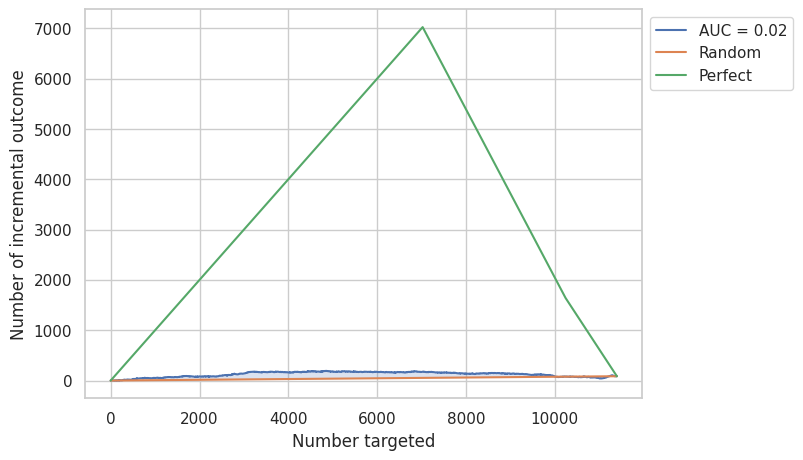

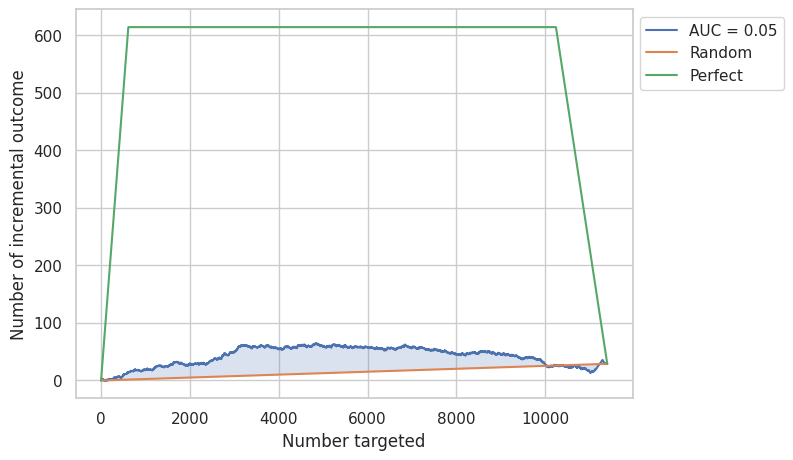

In [52]:
best_params = study.best_params

learner = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1
)

s_learner_best = BaseSClassifier(
    learner=learner,
    control_name=0
)

X_train_np = np.array(X_train.values, copy=True)
X_test_np = np.array(X_test.values, copy=True)

s_learner_best.fit(
    X=X_train_np,
    treatment=X_train["treatment"].values,
    y=y_train.values
)

uplift_pred_best = s_learner_best.predict(X_test_np).squeeze()

uplift_auc = uplift_auc_score(y_test, uplift_pred_best, X_test["treatment"].values)
qini_auc = qini_auc_score(y_test, uplift_pred_best, X_test["treatment"].values)
uplift_30 = uplift_at_k(y_test, uplift_pred_best, X_test["treatment"].values, k=0.3, strategy="overall")

print("Uplift AUC:", uplift_auc)
print("Qini AUC:", qini_auc)
print("Uplift@30%:", uplift_30)

plot_uplift_curve(y_test, uplift_pred_best, X_test["treatment"].values)
plot_qini_curve(y_test, uplift_pred_best, X_test["treatment"].values)


## Этап 2

### Визуализация результатов

In [53]:
from utils import custom_uplift_by_percentile

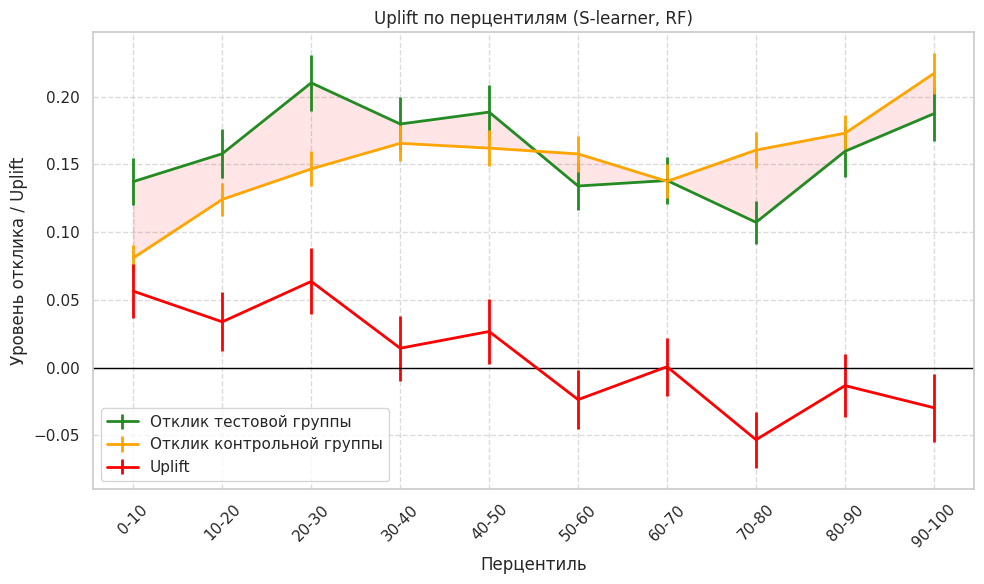

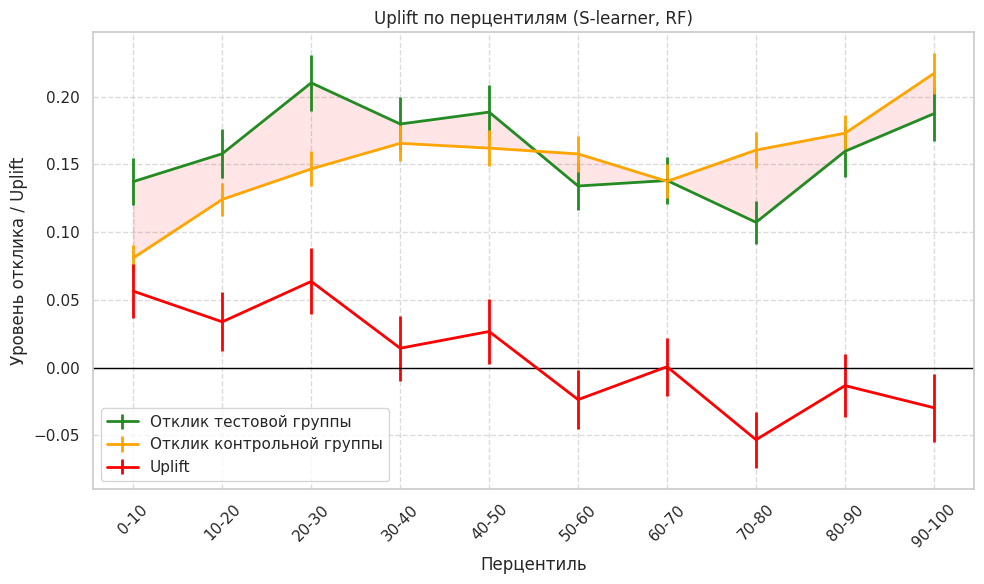

In [58]:
custom_uplift_by_percentile(
    y_true=y_test.values,
    uplift=uplift_preds_s,
    treatment=treatment_test.values,
    kind="line",
    bins=10,
    title="Uplift по перцентилям (S-learner, RF)"
)


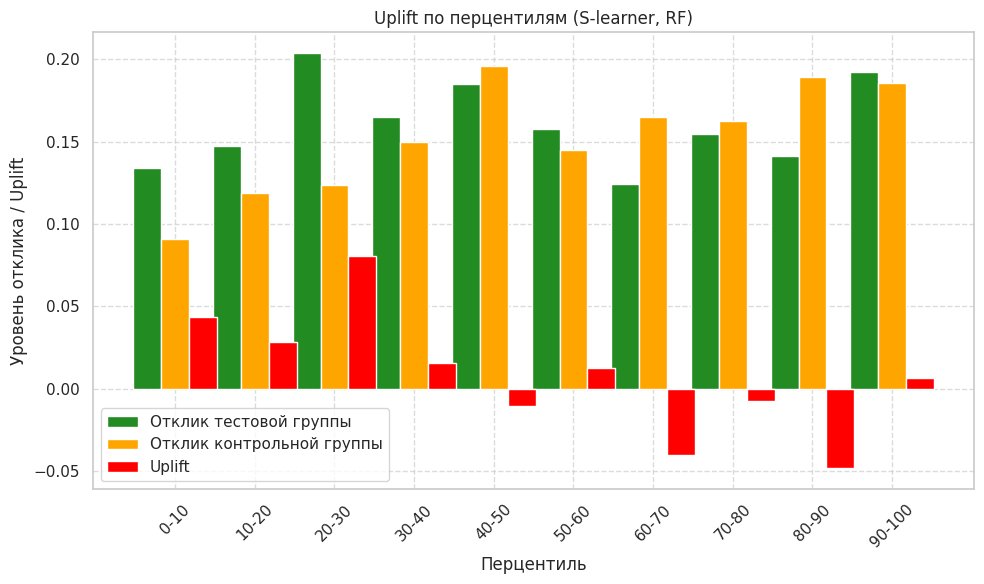

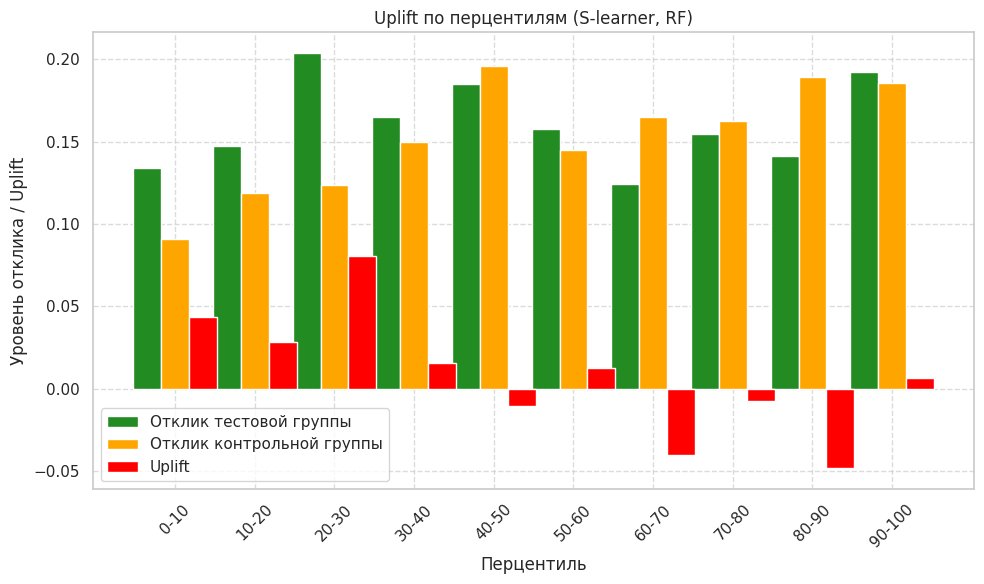

In [59]:
custom_uplift_by_percentile(
    y_true=y_test.values,
    uplift=uplift_pred_best,
    treatment=treatment_test.values,
    kind="bar",
    bins=10,
    title="Uplift по перцентилям (S-learner, RF)"
)


В данной ячейке сделайте вывод о качестве работы модели и проинтерпретируйте график `uplift by percentile` 

**Вывод по качеству модели и интерпретация uplift by percentile**

По результатам экспериментов видно, что исходная S-learner модель на RandomForest показывает наилучшее качество среди всех рассмотренных вариантов.

Попытки улучшить модель за счёт:
- смены алгоритма (CatBoost, LogisticRegression),
- ручного feature engineering,
- подбора гиперпараметров через Optuna
не привели к устойчивому росту метрик. В большинстве случаев Uplift@30 либо снижался, либо колебался в районе 0.04–0.049 и не превосходил исходный результат.

**Интерпретация графика uplift by percentile**

В верхних перцентилях (примерно 0–30%) наблюдается положительный uplift: отклик в тестовой группе стабильно выше, чем в контрольной.
Это означает, что модель корректно ранжирует пользователей и действительно выделяет аудиторию, для которой воздействие эффективно.

Начиная с средних и нижних перцентилей uplift снижается и местами становится отрицательным.
Это ожидаемое поведение для uplift-модели и подтверждает, что скидку имеет смысл применять только к верхней части ранжированного списка, а не ко всей аудитории.

Форма кривой соответствует корректной работе uplift-модели: максимум эффекта сосредоточен в верхних перцентилях, а не размазан равномерно.

**Итоговое решение**

Несмотря на дополнительные эксперименты, улучшить качество исходной модели не удалось.
Исходная S-learner модель с RandomForest остаётся наиболее стабильной и лучшей по целевой метрике Uplift@30.


# Этап 3

In [93]:
# Класс для инференса модели
class UpliftModelInference:
    """
    Класс для инференса uplift модели.
    """
    
    def __init__(self, model, feature_names, logger=None):
        """
        Инициализация класса.
        
        Аргументы:
            model: Обученная модель uplift
            feature_names: Список признаков для предсказания 
            logger: Объект для логирования (по умолчанию None)
        """
        self.model = model
        self.feature_names = ['treatment', 'recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
        self.logger = logger
        
        if self.logger:
            self.logger.info("Модель UpliftModel инициализирована с признаками: %s", feature_names)

    def _transform_data(self, X):
        """
        Преобразование данных для модели.
        
        Аргументы:
            X: pandas.DataFrame с признаками
        """
        if self.logger:
            self.logger.debug("Преобразование входных данных размерности %s", X.shape)
    

        return X
    
    def predict(self, X):
        """
        Получение предсказаний uplift.
        
        Аргументы:
            X: pandas.DataFrame с признаками
            
        Возвращает:
            numpy.array с предсказанными значениями uplift
        """
        # Проверяем, что датафрейм не пустой
        if X.empty:
            if self.logger:
                self.logger.error("Предоставлен пустой датафрейм")
            return None
            
        # Проверяем наличие пропущенных значений
        if X.isnull().any().any():
            if self.logger:
                self.logger.error("Входные данные содержат пропущенные значения")
            return [None]*len(X)
        
        if self.logger:
            self.logger.info("Выполняем предсказания для данных размерности %s", X.shape)

        # Проверяем наличие всех необходимых признаков
        missing_features = set(self.feature_names) - set(X.columns)
        if missing_features:
            error_msg = f"Отсутствуют признаки: {missing_features}"
            if self.logger:
                self.logger.error(error_msg)

            return [None]*len(X)
        
        # Преобразуем данные для модели
        if self.logger:
            self.logger.debug("Начинаем преобразование данных")
        X = self._transform_data(X)
        
        # Вычисляем uplift
        if self.logger:
            self.logger.debug("Выполняем предсказания модели")
        

        # Дополните код для получения предсказаний аплифта
        
        X_model = np.array(X[self.feature_names].values, copy=True)
        uplift = self.model.predict(X_model).squeeze()

        
        if self.logger:
            self.logger.info("Предсказания успешно завершены")
            
        return uplift


In [97]:
feature_names = ['treatment','recency','history_segment','history','mens','womens','zip_code','newbie','channel']

model = UpliftModelInference(s_learner, feature_names)


In [98]:
test_data = pd.DataFrame({
            'recency': [1, 2, 3],
            'history_segment': [1, 2, 3], 
            'history': [100, 200, 300],
            'mens': [1, 0, 1],
            'womens': [0, 1, 0],
            'zip_code': [1, 0, 1],
            'newbie': [0, 1, 0],
            'channel': [1, 2, 0],
            'treatment':[0,1,0]
        })

In [99]:
model.predict(test_data)

array([-0.01082764, -0.00878393, -0.00701469])